# ECE 253 Homework 3
#### Name: Sheng-Wei Chang
#### PID:  A53317226

Academic Integrity Policy: Integrity of scholarship is essential for an academic community. The University expects that both faculty and students will honor this principle and in so doing protect the validity of University intellectual work. For students, this means that all academic work will be done by the individual to whom it is assigned, without unauthorized aid of any kind. By including this in my report, I agree to abide by the Academic Integrity Policy mentioned above.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.signal import convolve
import warnings
warnings.filterwarnings('ignore')

## Problem 1. Canny Edge Detection

In [2]:
def CannyEdgeDetection(img, t):
    n, m = img.shape
    # Smoothing
    kg = np.array([[2,  4,  5,  4, 2],
                   [4,  9, 12,  9, 4],
                   [5, 12, 15, 12, 5],
                   [4,  9, 12,  9, 4],
                   [2,  4,  5,  4, 2]]) / 159
    img = convolve(img, kg, mode ='same')
    
    # Finding Gradients
    # x: left to right, y: top to bottom
    kx = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])
    ky = np.array([[-1,-2,-1],
                   [ 0, 0, 0],
                   [ 1, 2, 1]])
    Gx = convolve(img, kx, mode ='same')
    Gy = convolve(img, ky, mode ='same')
    Gm = np.sqrt(Gx**2 + Gy**2)
    Gd = np.arctan2(Gy, Gx)
    
    # Non-maximum Suppression
    Gd = np.round(Gd/(np.pi/4))
    nms = np.zeros_like(Gm)
    for i in range(n):
        for j in range(m):
            if Gd[i,j] == 3 or Gd[i,j] == -1:
                if Gm[i,j] >= Gm[min(n-1,i+1),max(0,j-1)] and Gm[i,j] >= Gm[max(0,i-1),min(n-1,j+1)]:
                    nms[i,j] = Gm[i,j]
            elif Gd[i,j] == 2 or Gd[i,j] == -2:
                if Gm[i,j] >= Gm[min(n-1,i+1),j] and Gm[i,j] >= Gm[max(0,i-1),j]:
                    nms[i,j] = Gm[i,j]
            elif Gd[i,j] == 1 or Gd[i,j] == -3:
                if Gm[i,j] >= Gm[min(n-1,i+1),min(m-1,j+1)] and Gm[i,j] >= Gm[max(0,i-1),max(0,j-1)]:
                    nms[i,j] = Gm[i,j]
            else:
                if Gm[i,j] >= Gm[i,min(m-1,j+1)] and Gm[i,j] >= Gm[i,max(0,j-1)]:
                    nms[i,j] = Gm[i,j]
                
    # Thresholding
    output = np.where(nms>t, 1, 0)
    
    return Gm, nms, output, Gd

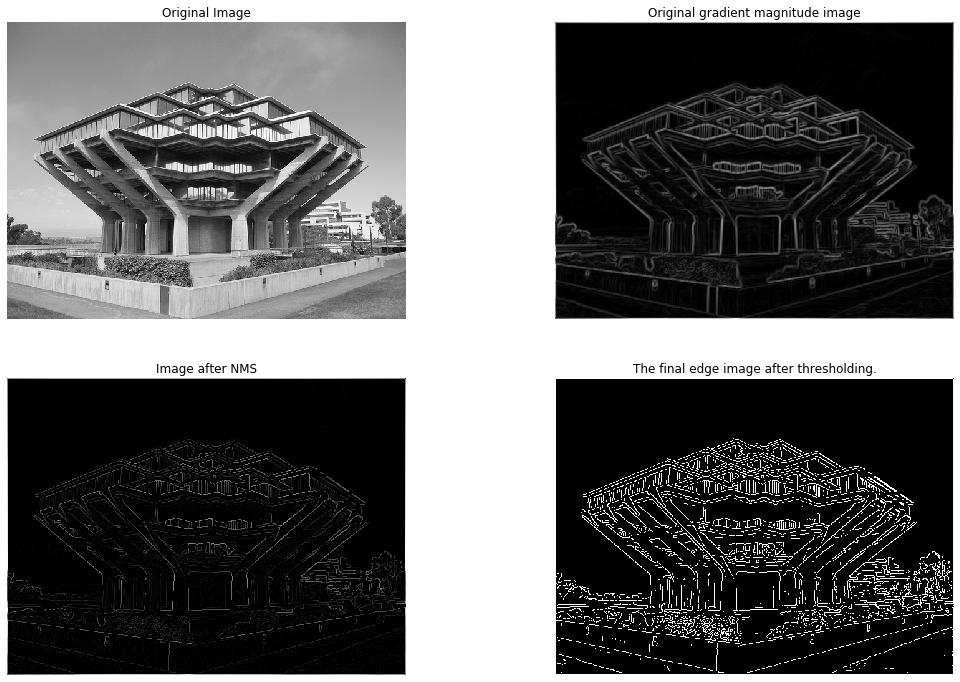

The value of te I used to produce the final edge image is 50.


In [3]:
# Read image
img = cv2.imread('images/geisel.jpg')

# Convert the image into grayscale before doing histogram equalization
geisel = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Histogram equalization
t = 50
Gm, nms, output, Gd = CannyEdgeDetection(geisel, t)

# plot
plt.figure(figsize=(18,12))
plt.subplot(2,2,1)
plt.title('Original Image')
plt.imshow(geisel, cmap='gray')
plt.axis('off')
plt.subplot(2,2,2)
plt.title('Original gradient magnitude image')
plt.imshow(Gm, cmap='gray')
plt.axis('off')
plt.subplot(2,2,3)
plt.title('Image after NMS')
plt.imshow(nms, cmap='gray')
plt.axis('off')
plt.subplot(2,2,4)
plt.title('The final edge image after thresholding.')
plt.imshow(output, cmap='gray')
plt.axis('off')
plt.show()

print('The value of te I used to produce the final edge image is %d.' %t)

## Problem 2. Butterworth Notch Reject Filtering in Frequency Domain

In [4]:
def padding(img):
    n, m = img.shape
    return np.pad(img, (((512-n)//2, 512-n-(512-n)//2), ((512-m)//2, 512-m-(512-m)//2)), 'constant')
    
def fft(img):
    out = np.fft.fftshift(np.fft.fft2(img))
    return out, np.log(np.abs(out))

def ifft(img):
    f_ishift = np.fft.ifftshift(img)
    return np.abs(np.fft.ifft2(f_ishift))

def butterworth_notch_reject_filter(K, n, D0, uk, vk):
    x_axis = np.linspace(-256,255,512)
    y_axis = np.linspace(-256,255,512)
    [u,v] = np.meshgrid(x_axis,y_axis)
    
    H = np.ones((512, 512))
    for k in range(K):
        Dp = np.sqrt((u-uk[k])**2 + (v-vk[k])**2)
        Dn = np.sqrt((u+uk[k])**2 + (v+vk[k])**2)
        H *= (1/(1+(D0/Dp)**(2*n))) * (1/(1+(D0/Dn)**(2*n)))
    return H

def plot_results(img1, img2, img3, img4, img5):
    plt.figure(figsize=(18, 12))
    plt.subplot(2,3,1)
    plt.imshow(img1, cmap='gray')
    plt.title('Original image')
    plt.axis('off')
    plt.colorbar()
    plt.subplot(2,3,2)
    plt.imshow(img2, cmap='gray')
    plt.title('FT log-magnitude')
    plt.axis('off')
    plt.colorbar()
    plt.subplot(2,3,4)
    plt.imshow(img3, cmap='gray')
    plt.title('Butterworth Filter in frequency domain')
    plt.colorbar()
    plt.subplot(2,3,5)
    plt.imshow(img4, cmap='gray')
    plt.title('FT log-magnitude times a Butterworth filter')
    plt.axis('off')
    plt.colorbar()
    plt.subplot(2,3,6)
    plt.imshow(img5, cmap='gray')
    plt.title('Filtered image')
    plt.axis('off')
    plt.colorbar()
    
    plt.show()

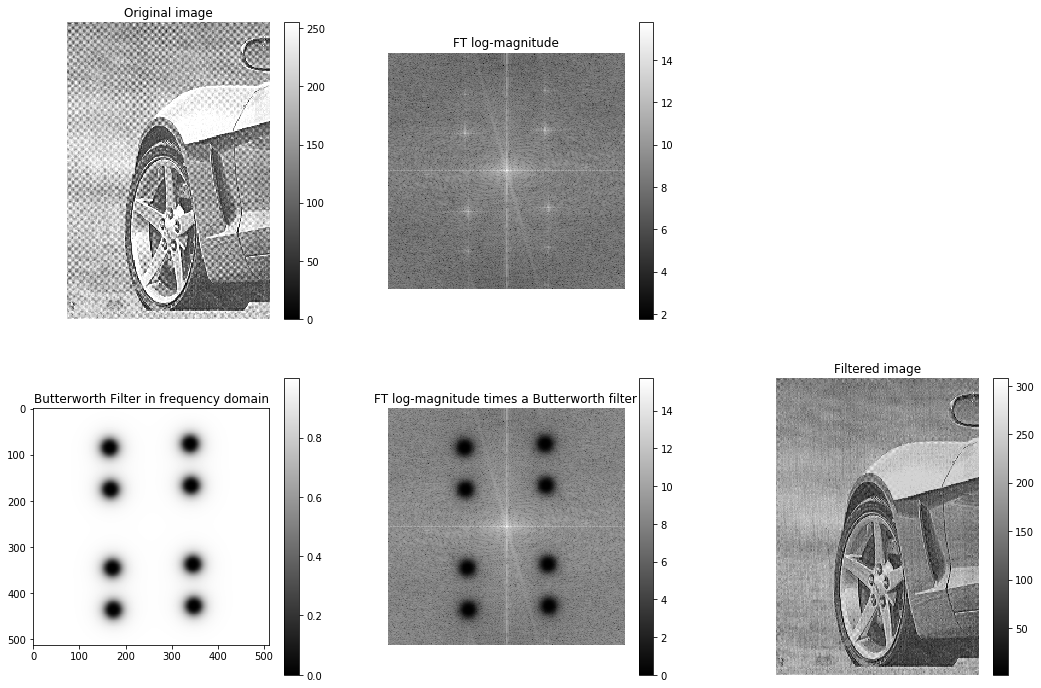

Prarmeters for 2 (i):
n : 2
D0: 20
u1, v1:  -91, -171
u2, v2:  -89,  -81
u3, v3:  -85,   89
u4, v4:  -83,  179


In [5]:
# Car
img = cv2.imread('images/Car.tif')
car = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
car_ft, car_ft_log = fft(padding(car))

K = 4
n = 2
D0 = 20
uk = np.array([165, 167, 171, 173]) - 256
vk = np.array([ 85, 175, 345, 435]) - 256

H = butterworth_notch_reject_filter(K, n, D0, uk, vk)
car_ft_n = car_ft_log * H
car_filtered = ifft(car_ft * H)
plot_results(car, car_ft_log, H, car_ft_n, car_filtered[133:379,172:340])

# 10 parameters for 2(i): n, D0, u1, v1, ..., u4, v4
print('Prarmeters for 2 (i):')
print('n : %d' % n)
print('D0: %d' % D0)
print('u1, v1: %4d, %4d' % (uk[0], vk[0]))
print('u2, v2: %4d, %4d' % (uk[1], vk[1]))
print('u3, v3: %4d, %4d' % (uk[2], vk[2]))
print('u4, v4: %4d, %4d' % (uk[3], vk[3]))

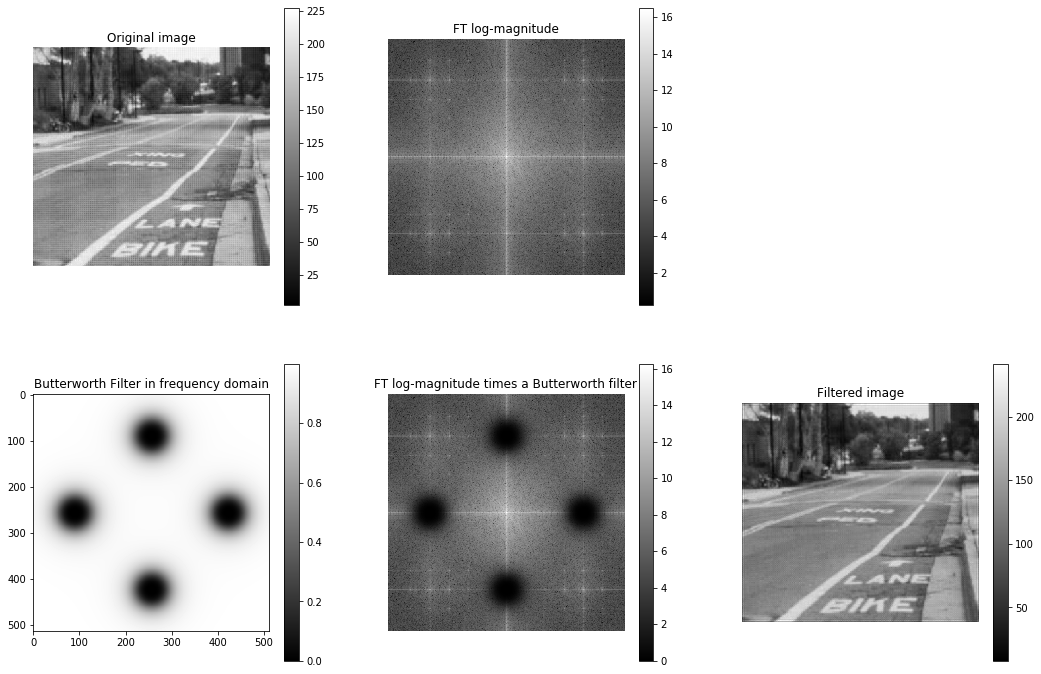

Prarmeters for 2 (ii):
n : 2
D0: 40
u1, v1: -166,    0
u2, v2:    0, -166


In [6]:
# Street
img = cv2.imread('images/Street.png')
street = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
street_ft, street_ft_log = fft(padding(street))

K = 2
n = 2
D0 = 40
uk = np.array([ 90, 256]) - 256
vk = np.array([256,  90]) - 256

H = butterworth_notch_reject_filter(K, n, D0, uk, vk)
street_ft_n = street_ft_log * H
street_filtered = ifft(street_ft * H)
plot_results(street, street_ft_log, H, street_ft_n, street_filtered[90:422,76:435])

# 6 parameters for 2(ii): n, D0, u1, v1, u2, v2
print('Prarmeters for 2 (ii):')
print('n : %d' % n)
print('D0: %d' % D0)
print('u1, v1: %4d, %4d' % (uk[0], vk[0]))
print('u2, v2: %4d, %4d' % (uk[1], vk[1]))

## Problem 3. PyTorch tutorial and questions

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
net = net.to(device)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
training_loss = []
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        # inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            training_loss.append(running_loss / 2000)
            running_loss = 0.0

print('Finished Training')

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
images, labels = data[0].to(device), data[1].to(device)
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        # images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        # images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

#### How many images and batches are used to train the network?

In [ ]:
trainset

There are 50000 images used to train the network. The batch size is 4, so the there are 50000/4=12500 batches are used to train the network. 

#### Do we normalize the images? What do we do in the example?
Yes, we normalize the images. The outputs of torchvision datasets are PILImage images of range [0, 1]. However, we need to normalize them to Tensors of normalized range [-1, 1], such that the mean is at 0. Thus, we use the formula below.

$$output = \frac{input-mean}{std}$$

We set both mean and set as 0.5. When the input is 0, the output is -1. When the input is 1, the output is 1. Also, this is a linear transformation.

#### The losses are dropping! Can you plot out the training loss?

In [ ]:
import matplotlib.pyplot as plt

plt.plot(training_loss)
plt.title('Tranining loss')
plt.grid(True)
plt.show()

#### Now the network is done training. Can you check some successful cases and some failure cases (show some images classified by the network)?

In [ ]:
dataiter = iter(testloader)
data = dataiter.next()
images, labels = data[0].to(device), data[1].to(device)

outputs = net(images)
_, predicted = torch.max(outputs.data, 1)

# print images
imshow(torchvision.utils.make_grid(images.cpu()))
print('GroundTruth:', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
print('Predicted:  ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))
print('The 1st and 4th images are successful cases. Their predicted labels are correct).')
print('The 2nd and 3rd image is a failure case.')

#### Can you visualize the output of the 1st layer of CNN using one image from the training set?

In [ ]:
class FirstNN(nn.Module):
    def __init__(self):
        super(FirstNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # (number of input channels, number of output channels, kernel size)

    def forward(self, x):
        return self.conv1(x)

net_1st_layer = FirstNN().to(device)

In [ ]:
data = next(iter(testloader))
image, labels = data[0].to(device), data[1].to(device)
out = net_1st_layer(image)
print(out.shape) # (batch size, number of output channels, (32−5)+1=28)

In [ ]:
#image after convolution
image_1st_layer = out[0,:,:,:]

plt.figure(figsize = (12,5))
plt.subplot(2, 4, 1)
plt.imshow(image[0].cpu().numpy().transpose(1,2,0)*0.5+0.5)
plt.title('Input')
plt.axis('off')
for i in range(6):
    plt.subplot(2, 4, i+2)
    plt.imshow(image_1st_layer[i].detach().cpu().numpy())
    plt.title('Output: Channel %d' % (i+1))
    plt.axis('off')
plt.show()